In [25]:
import numpy as np
import matplotlib.pyplot as plt

from config import Config
from playground.environment import Environment

config = Config()
config.OBJ_NUM = 51
environment = Environment(config)

In [26]:
for o in environment.get_objects():
    print(o.name, o.task)

banana Task.GRASPING
bike Task.GRASPING
chips_can Task.GRASPING
cracker_box Task.GRASPING
domino Task.GRASPING
hammer Task.GRASPING
jenga Task.GRASPING
master_chef_can Task.GRASPING
medium_clamp Task.GRASPING
mini_cheetah Task.GRASPING
minitaur Task.GRASPING
mug Task.GRASPING
mustard_bottle Task.GRASPING
power_drill Task.GRASPING
scissors Task.GRASPING
tomato_soup_can Task.GRASPING
007 Task.PUSHING
014 Task.PUSHING
024 Task.PUSHING
033 Task.PUSHING
088 Task.PUSHING
117 Task.PUSHING
119 Task.PUSHING
132 Task.PUSHING
133 Task.PUSHING
184 Task.PUSHING
185 Task.PUSHING
228 Task.PUSHING
238 Task.PUSHING
banana Task.PUSHING
cracker_box Task.PUSHING
gelatin_box Task.PUSHING
mug Task.PUSHING
power_drill Task.PUSHING
000 Task.HAMMERING
007 Task.HAMMERING
011 Task.HAMMERING
016 Task.HAMMERING
024 Task.HAMMERING
057 Task.HAMMERING
058 Task.HAMMERING
078 Task.HAMMERING
081 Task.HAMMERING
083 Task.HAMMERING
090 Task.HAMMERING
114 Task.HAMMERING
115 Task.HAMMERING
126 Task.HAMMERING
147 Task.HAMMERI

In [27]:
ls = environment.storage._latent_similarities

In [28]:
vs = np.zeros((config.OBJ_NUM, config.OBJ_NUM))
for i in range(config.OBJ_NUM):
    for j in range(config.OBJ_NUM):
        if environment.get_objects()[i].task != environment.get_objects()[j].task:
            continue
        vs[i, j] = environment.storage.get_visual_similarity(i, j)

In [29]:
print(ls)
print(vs)

[[0.9 0.1 0.  ... 0.  0.  0. ]
 [0.3 0.9 0.1 ... 0.  0.  0. ]
 [0.  0.  1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.7 0.7 0.4]
 [0.  0.  0.  ... 0.2 0.9 0.4]
 [0.  0.  0.  ... 0.  0.  0.8]]
[[1.         0.28450832 0.28372762 ... 0.         0.         0.        ]
 [0.28450832 1.         0.48345186 ... 0.         0.         0.        ]
 [0.28372762 0.48345186 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.57863038 0.17559369]
 [0.         0.         0.         ... 0.57863038 1.         0.12940964]
 [0.         0.         0.         ... 0.17559369 0.12940964 1.        ]]


The format of the data is as follows:
All values are between 0 and 1. The visual similarity of objects in different tasks is manually set to 0, since transferring between tasks does not make much sense. Thus, the two matrices are block diagonal, with 3 non-zero blocks for the three tasks. 

In [30]:
print("Average visual similarity", vs.mean(), vs.std())
print("Average real transfer success rate", ls.mean(), ls.std())

Average visual similarity 0.17769257474392536 0.2950665670453092
Average real transfer success rate 0.13429450211457133 0.2541927769683696


It seems the average visual similarity is higher than the average transfer success rate, which makes sense, since even objects that are quite different will have some visual similarity but they can easily have 0 transfer successes. Also, the standard deviation of the visual similarity dataset is higher. 

In [31]:
ls_flat = ls.flatten()
vs_flat = vs.flatten()

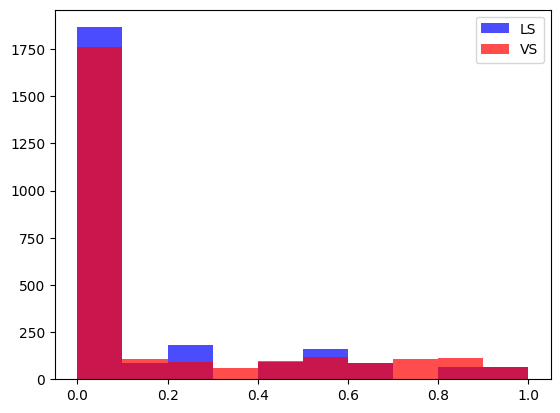

In [32]:
bins = np.histogram(np.hstack((list(ls_flat), list(vs_flat))), bins=10)[1]
plt.hist(list(ls_flat), bins, alpha=0.7, label='LS', color='b')
plt.hist(list(vs_flat), bins, alpha=0.7, label='VS', color='r')
plt.legend()
plt.show()

As expected, most values in both arrays are zeros. It seems the real transfers have more zeros (which is expected because there will always be some similarity between two images whereas transferring from one object to another can easily have exactly 0 successes).

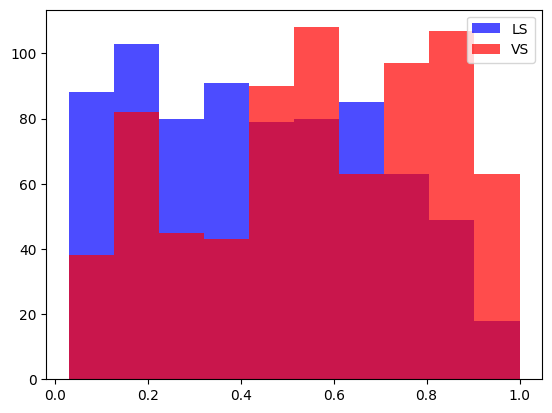

In [33]:
# filter out the zeros in the latent similarities
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
bins = np.histogram(np.hstack((list(ls_flat_filtered), list(vs_flat_filtered))), bins=10)[1]
plt.hist(list(ls_flat_filtered), bins, alpha=0.7, label='LS', color='b')
plt.hist(list(vs_flat_filtered), bins, alpha=0.7, label='VS', color='r')
plt.legend()
plt.show()

Having filtered out the zeros in the latent similarities we get a nice and readable histogram which shows that the visual similarities have a distribution which could be approximated with two Gaussians, whereas the distribution of the transfer success rate looks more like a flat single Gaussian. I suspect the reason is the PUSHING and HAMMERING tasks result in this bulge in the high visual similarities, since all those objects are visually quite similar but have slightly different interaction dynamics. It might be thus necessary to consider the distributions separately for each task.

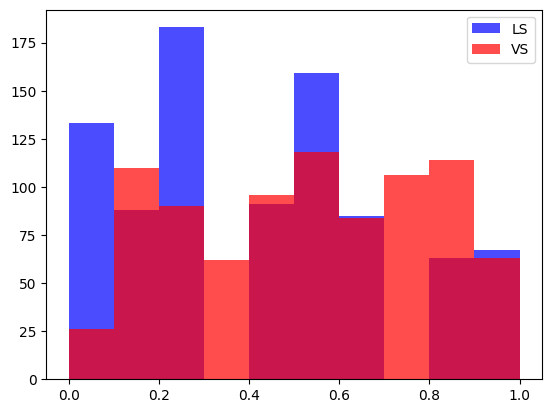

In [34]:
# filter out the zeros in the visual similarities
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
bins = np.histogram(np.hstack((list(ls_flat_filtered), list(vs_flat_filtered))), bins=10)[1]
plt.hist(list(ls_flat_filtered), bins, alpha=0.7, label='LS', color='b')
plt.hist(list(vs_flat_filtered), bins, alpha=0.7, label='VS', color='r')
plt.legend()
plt.show()

The histogram with zeros in the visual similarities is harder to interpret. Logically, this should filter out only the zeros from different tasks. The transfer success rate distribution looks very choppy, with three separate peaks. 

In [35]:
print("Average visual similarity", vs_flat_filtered.mean(), vs_flat_filtered.std())
print("Average real transfer success rate", ls_flat_filtered.mean(), ls_flat_filtered.std())

Average visual similarity 0.5318508479964901 0.2687607202458642
Average real transfer success rate 0.4019562715765247 0.292929087548136


Computing the mean and standard deviation of the filtered datasets yields results as expected. The average visual similarity is higher by about 0.1 and the dataset has a slightly higher standard deviation.

## Let us now investigate the correlation between the two features
First, let's plot one against the other

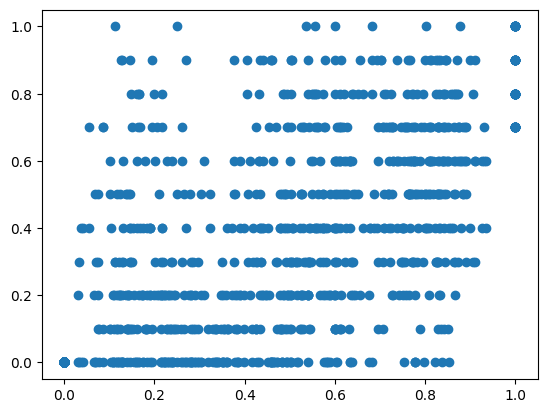

In [36]:
plt.scatter(vs_flat, ls_flat)

Visually, the two features don't look too correlated, but we can filter out zeros as before to hopefully make it more readable

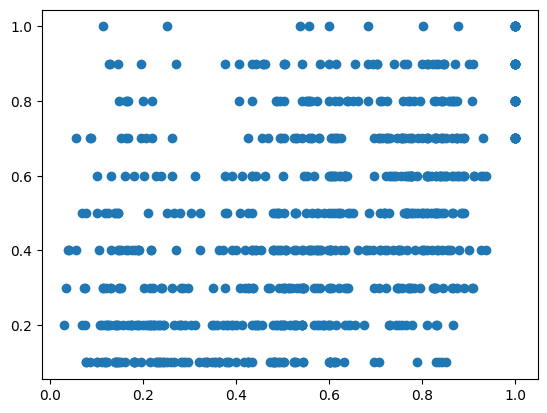

In [37]:
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
plt.scatter(vs_flat_filtered, ls_flat_filtered)

While the number of zeros is much smaller and the density of the data is moved more towards larger visible similarity, the distribution looks very noisy.

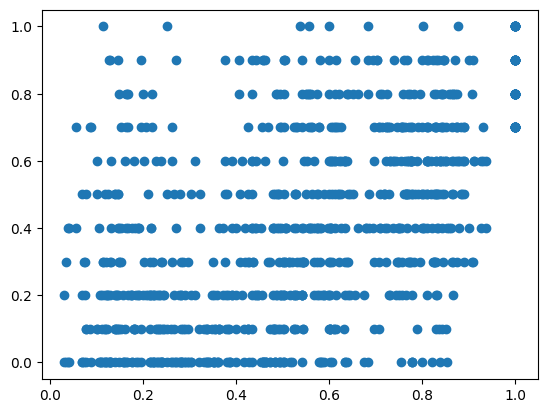

In [38]:
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
plt.scatter(vs_flat_filtered, ls_flat_filtered)

Let us now calculate some correlation coefficients, starting with Pearson's.

In [39]:
from scipy.stats import pearsonr

corr, _ = pearsonr(vs_flat, ls_flat)
print("The Pearson's correlation of the whole dataset", corr)
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
corr, _ = pearsonr(vs_flat_filtered, ls_flat_filtered)
print("The Pearson's correlation of the dataset with latent zeros filtered out", corr)
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
corr, _ = pearsonr(vs_flat_filtered, ls_flat_filtered)
print("The Pearson's correlation of the dataset with visible zeros filtered out", corr)

The Pearson's correlation of the whole dataset 0.814183100423068
The Pearson's correlation of the dataset with latent zeros filtered out 0.45825290457707024
The Pearson's correlation of the dataset with visible zeros filtered out 0.5134484151172747


It can be seen that we only get significant correlation when zeros are not filtered out. This is however meaningless, since the zeros are manually set for objects that don't share tasks and it has no predictive value for the application.

Let us now see if some other coefficients might work better for the data. Let us consider Spearman's Correlation which summarises the strength between two data samples.  

In [40]:
from scipy.stats import spearmanr

corr, _ = spearmanr(vs_flat, ls_flat)
print("The Spearman's correlation of the whole dataset", corr)
ls_flat_filtered = ls_flat[ls_flat > 0]
vs_flat_filtered = vs_flat[ls_flat > 0]
corr, _ = spearmanr(vs_flat_filtered, ls_flat_filtered)
print("The Spearman's correlation of the dataset with latent zeros filtered out", corr)
ls_flat_filtered = ls_flat[vs_flat > 0]
vs_flat_filtered = vs_flat[vs_flat > 0]
corr, _ = spearmanr(vs_flat_filtered, ls_flat_filtered)
print("The Spearman's correlation of the dataset with visible zeros filtered out", corr)

The Spearman's correlation of the whole dataset 0.8971861363040191
The Spearman's correlation of the dataset with latent zeros filtered out 0.4685917110611846
The Spearman's correlation of the dataset with visible zeros filtered out 0.5151086910938244


Again, the only meaningful correlation is found for the non-filtered data. Perhaps considering the entire dataset is not a good idea.

## Considering tasks separately

In [41]:
start_g, stop_g = 0, 16 
start_p, stop_p = 17, 34 
start_h, stop_h = 35, 51 
grasping_ls = ls[start_g: stop_g, start_g: stop_g]
grasping_vs = vs[start_g: stop_g, start_g: stop_g]
pushing_ls = ls[start_p: stop_p, start_p: stop_p]
pushing_vs = vs[start_p: stop_p, start_p: stop_p]
hammering_ls = ls[start_h: stop_h, start_h: stop_h]
hammering_vs = vs[start_h: stop_h, start_h: stop_h]

print(grasping_ls)
print(grasping_vs)
print(pushing_ls)
print(pushing_vs)
print(hammering_ls)
print(hammering_vs)

[[0.9 0.1 0.  0.6 0.  1.  0.  0.  0.5 0.4 0.5 0.3 0.  0.7 0.4 0.2]
 [0.3 0.9 0.1 0.9 0.1 0.9 0.4 0.3 0.7 0.8 0.9 0.6 0.1 0.7 0.6 0. ]
 [0.  0.  1.  0.2 0.4 0.  0.  0.7 0.  0.5 0.  0.5 0.4 0.1 0.  0.8]
 [0.1 0.4 0.1 1.  0.4 0.2 0.6 0.2 0.  0.7 1.  0.6 0.5 0.9 0.4 0.4]
 [0.2 0.  0.  0.2 0.9 0.3 0.  0.  0.2 0.1 0.3 0.  0.  0.  0.2 0. ]
 [0.3 0.  0.  0.4 0.2 1.  0.6 0.3 0.  0.  0.  0.1 0.  0.3 0.2 0. ]
 [0.2 0.9 0.3 0.9 0.2 0.3 1.  0.4 0.4 0.2 0.4 0.2 0.1 0.4 0.4 0.2]
 [0.  0.  0.7 0.  0.3 0.  0.  0.8 0.  0.3 0.1 0.6 0.7 0.1 0.  0.6]
 [0.2 0.8 0.  0.2 0.2 0.9 0.4 0.2 1.  0.9 0.8 0.7 0.1 0.5 0.8 0. ]
 [0.5 0.6 0.1 0.6 0.4 0.7 0.5 0.9 0.7 1.  1.  0.7 0.1 0.9 0.7 0.3]
 [0.  0.6 0.  0.  0.1 0.5 0.5 0.3 0.6 0.9 1.  0.4 0.1 0.1 0.7 0.1]
 [0.  0.  0.5 0.1 0.2 0.1 0.  0.3 0.  0.4 0.1 1.  0.4 0.  0.  0.7]
 [0.  0.  0.5 0.1 0.2 0.  0.  0.2 0.  0.2 0.1 0.3 0.7 0.1 0.  0.8]
 [0.1 0.  0.2 0.7 0.1 0.7 0.1 0.4 0.2 0.5 0.8 0.8 0.5 1.  0.2 0. ]
 [0.8 0.2 0.  0.3 0.  0.8 0.4 0.  0.9 0.8 0.4 0.2 0.  0.5 0.8 

In [42]:
def print_basic_info(vs, ls, task):
    print("Average visual similarity", vs.mean(), vs.std(), "for task", task)
    print("Average real transfer success rate", ls.mean(), ls.std(), "for task", task)
    

print_basic_info(grasping_vs, grasping_ls, "grasping")
print_basic_info(pushing_vs, pushing_ls, "pushing")
print_basic_info(hammering_vs, hammering_ls, "hammering")

Average visual similarity 0.3797145929082994 0.2264648144451832 for task grasping
Average real transfer success rate 0.350390625 0.3216167710367564 for task grasping
Average visual similarity 0.5261544781348485 0.27541863472573425 for task pushing
Average real transfer success rate 0.38823529411764707 0.3077994223988501 for task pushing
Average visual similarity 0.6539673215197672 0.23426399513099883 for task hammering
Average real transfer success rate 0.4609375 0.24262058052389127 for task hammering


As expected and described above, PUSHING and HAMMERING tasks have significantly higher visual similarity scores across all objects. The transfer success rates are more or less similar for all three tasks and are around 0.4. That means breaking up the data by task was a good approach.

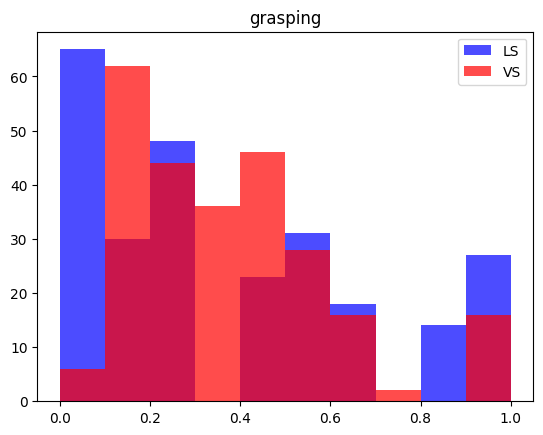

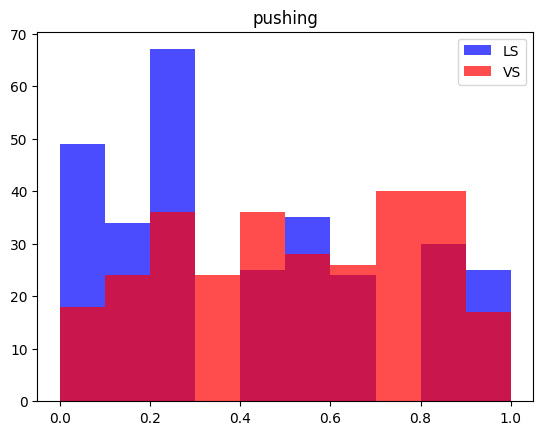

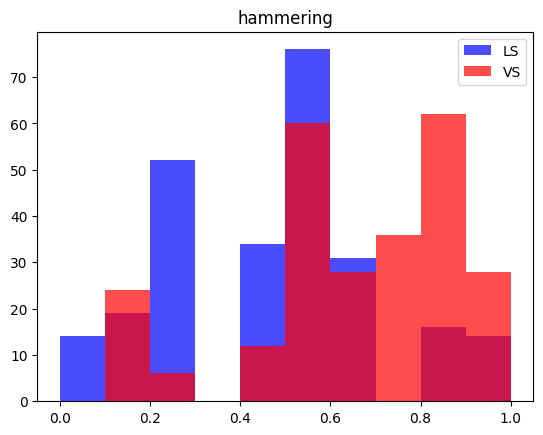

In [43]:
def show_histograms(vs, ls, task):
    bins = np.histogram(np.hstack((list(ls), list(vs))), bins=10)[1]
    plt.hist(list(ls), bins, alpha=0.7, label='LS', color='b')
    plt.hist(list(vs), bins, alpha=0.7, label='VS', color='r')
    plt.legend()
    plt.title(task)
    plt.show()
    
    
show_histograms(grasping_vs.flatten(), grasping_ls.flatten(), "grasping")
show_histograms(pushing_vs.flatten(), pushing_ls.flatten(), "pushing")
show_histograms(hammering_vs.flatten(), hammering_ls.flatten(), "hammering")

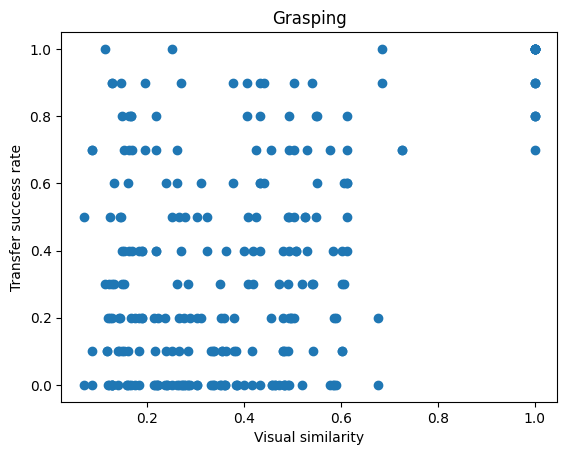

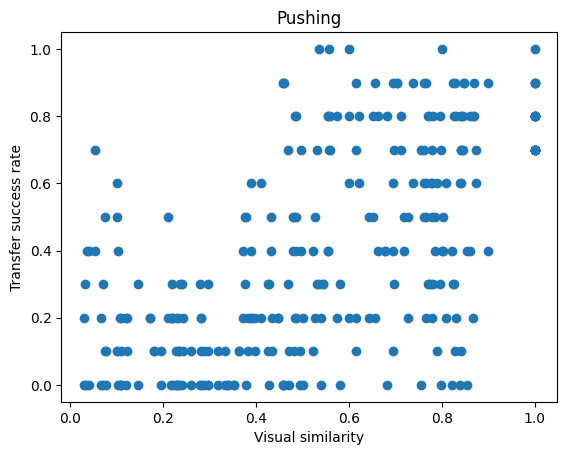

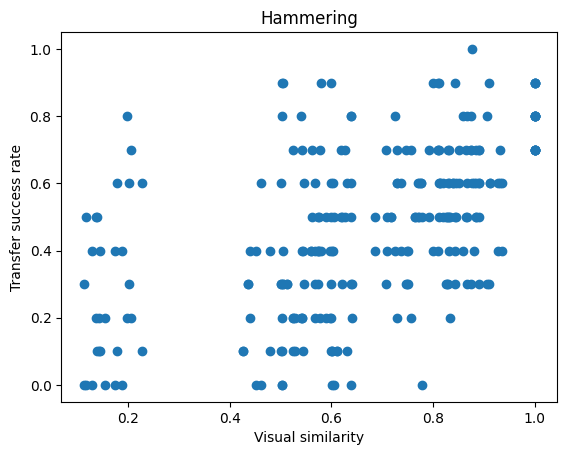

In [48]:
def plot_scatter(vs, ls, task):
    plt.scatter(vs, ls)
    plt.xlabel("Visual similarity")
    plt.ylabel("Transfer success rate")
    plt.title(task)
    plt.show()
    
    
plot_scatter(grasping_vs.flatten(), grasping_ls.flatten(), "Grasping")
plot_scatter(pushing_vs.flatten(), pushing_ls.flatten(), "Pushing")
plot_scatter(hammering_vs.flatten(), hammering_ls.flatten(), "Hammering")

In [45]:
def print_correlation_coefficients(vs, ls, task):
    corr, _ = pearsonr(vs, ls)
    print("The Pearson's correlation for task", task, "is", corr)
    corr, _ = spearmanr(vs, ls)
    print("The Spearman's correlation for task", task, "is", corr)
    
    
print_correlation_coefficients(grasping_vs.flatten(), grasping_ls.flatten(), "grasping")
print_correlation_coefficients(pushing_vs.flatten(), pushing_ls.flatten(), "pushing")
print_correlation_coefficients(hammering_vs.flatten(), hammering_ls.flatten(), "hammering")

The Pearson's correlation for task grasping is 0.40220500904683276
The Spearman's correlation for task grasping is 0.2570145768627124
The Pearson's correlation for task pushing is 0.5967373581928388
The Spearman's correlation for task pushing is 0.5888542799922021
The Pearson's correlation for task hammering is 0.5146791925621697
The Spearman's correlation for task hammering is 0.535856277808927


The correlation coefficients are still rather low, and all apart from PUSHING are not high enough to be notable. This is an interesting result, since the objects used for the pushing task are all relatively similar and I would expect the DINO similarities to be high for any pair. However, we can see from the above histogram, that the visual similarity measures are roughly evenly distributed. 